In [26]:
import pybammeis
import pybamm
import os
import re
import numpy as np
from gamry_parser import GamryParser, Impedance
import pandas as pd
import time as timer
import matplotlib.pyplot as plt
from scipy.fft import fft
import random
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from scipy.interpolate import interp1d
import pyswarms as ps 
from pyswarms.single import GlobalBestPSO

Uploading experimental data

In [27]:
# ved ca. 45% SoC 
# ved 25 deg C

def get_exp_data(i, d): 
    z_list = []
    file = "/Users/synnemard/Desktop/lithium_ion/EIS_data/MJ1_01_EIS-SoC_01-05/MJ1_01_EIS-SoC_0"+str(i)+"/"+d+"EISGALV3V587.DTA"
    ca = Impedance(file)
    ca.load(filename=file)

    # extract EIS curve
    res = ca.get_curve_data().iloc[::-1]
    df_real = res['Zreal']
    df_imag= res['Zimag']
    df_freq = res['Freq']
    #df_name = res['Vdc']

    # Removing the points beneath the y-axis 
    real = df_real[df_imag <= 0]
    imag = df_imag[df_imag <= 0]
    freq = df_freq[df_imag <= 0]
    
    #name = sum(df_name)/len(df_name)
    # Adding the impendances to the list 
    z_list.append(real)
    z_list.append(imag)
    return[z_list, freq, len(freq)] #, df_name]


In [17]:
def get_vdc(i, d): 
    length = get_exp_data(i, d)[2]
    file = "/Users/synnemard/Desktop/lithium_ion/EIS_data/MJ1_01_EIS-SoC_01-05/MJ1_01_EIS-SoC_0"+str(i)+"/"+d+"EISGALV3V587.DTA"
    df = pd.read_csv(file, delimiter='\t', skiprows=[i for i in range(0, 60)], encoding='ISO-8859-1')

    df_vdc = df['Vdc'][::-1]
    vdc = df_vdc[:length+1]
    v_list = np.array(vdc)

    sum = 0 
    for i in v_list: 
        sum += float(i) 
    v_avg = sum/len(v_list)

    return v_avg #, df_name]

get_vdc(1, "")

3.572173346938775

Defining parameters

In [28]:
# OCV curves for the anode and cathode
# Simple math model for the individual electrode potentials as a function of the stoichiometry of Lithium

c_n_max = params["Maximum concentration in negative electrode [mol.m-3]"]
c_p_max = params["Maximum concentration in positive electrode [mol.m-3]"]

params.set_initial_stoichiometries(f'0.45') # Setting SOC
c_n = params['Initial concentration in negative electrode [mol.m-3]'] 
c_p = params['Initial concentration in positive electrode [mol.m-3]'] 


def MJ1_ocp_tanh_SiC(c):
    #x = sto
    x = c/c_n_max
    p = np.array([ 1.20912055e+00,  5.62297420e+01, -1.11020020e-01, -2.53458213e-01, 4.92581391e+01,  1.22046522e-02,  4.73538620e-02,  1.79631246e+01, 1.75283209e-01,  1.88038929e-02,  3.03255334e+01,  4.66328034e-01])
    
    U_c = p[0] * np.exp(-p[1] * x)
            + p[2]
            - p[3] * np.tanh(p[4] * (x - p[5]))
            - p[6] * np.tanh(p[7] * (x - p[8]))
            - p[9] * np.tanh(p[10] * (x - p[11]))
    return U_c

def dU_dc(c): 
    x = c/c_n_max
    p = np.array([ 1.20912055e+00,  5.62297420e+01, -1.11020020e-01, -2.53458213e-01, 4.92581391e+01,  1.22046522e-02,  4.73538620e-02,  1.79631246e+01, 1.75283209e-01,  1.88038929e-02,  3.03255334e+01,  4.66328034e-01])
    dU_dc = -p[6]*p[7]*pybamm.sech(p[7]*(x-p[8]))**2 - p[3]*p[4]*pybamm.sech(p[4]*(x-p[5]))**2 - p[9]*p[10]*pybamm.sech(p[10]*(x-p[11]))**2 - p[0]*p[1]*np.exp(-p[1]*x)
    return dU_dc


def MJ1_ocp_tanh_NMC(sto):
    #x = sto
    x = sto*c_p_max
    p = np.array([ 0.74041974,  4.39107343,  0.03434767, 18.16841489,  0.53463176, 17.68283504, 14.59709162,  0.28835348, 17.58474971, 14.69911523,  0.28845641])

    return (
            -p[0] * x
            + p[1]
            - p[2] * pybamm.tanh(p[3] * (x - p[4]))
            - p[5] * pybamm.tanh(p[6] * (x - p[7]))
            + p[8] * pybamm.tanh(p[9] * (x - p[10]))
        )

# Parameters from literature
literature_params = {
    'Electrode height [m]': 0.059,
    'Electrode width [m]': 0.610*2, # Multiplying by two since the electrode has active material on both sides.
    'Lower voltage cut-off [V]': 2.5,
    'Upper voltage cut-off [V]': 4.5,
    'Nominal cell capacity [A.h]': 3.5,

 # From Table 3 in https://doi.org/10.1016/j.jpowsour.2018.11.043
    'Maximum concentration in negative electrode [mol.m-3]': 32418.5,
    'Negative particle radius [m]': 6.1e-06,
    'Negative electrode porosity': 0.216,
    'Negative electrode active material volume fraction': 0.7011854763922494,
    'Negative electrode conductivity [S.m-1]': 100.0,
    'Negative electrode diffusivity [m2.s-1]': 5e-14,
    'Negative electrode OCP [V]': MJ1_ocp_tanh_SiC,

    # 'Maximum concentration in positive electrode [mol.m-3]': 51081.15,
    'Positive particle radius [m]': 3.8e-06,
    'Positive electrode porosity': 0.171,
    'Positive electrode active material volume fraction': 0.7355902286855152,
    'Positive electrode conductivity [S.m-1]': 0.17,
    'Positive electrode diffusivity [m2.s-1]': 5e-13,
    'Positive electrode OCP [V]': MJ1_ocp_tanh_NMC,

    'Separator porosity': 0.45,

    # end of section 3 data
    
    # From Table A-9 and A-10 in https://doi.org/10.1016/j.jpowsour.2018.11.043
    'Negative current collector conductivity [S.m-1]': 5.9e7/(1+3.383e-3 * (298.15-293.15)), 
    'Negative current collector thickness [m]': 11e-06,
    'Negative current collector density [kg.m-3]': 8950.0,
    'Negative current collector specific heat capacity [J.kg-1.K-1]': 385.0,
    'Negative current collector thermal conductivity [W.m-1.K-1]': 398.0,
    'Negative electrode density [kg.m-3]': 2242.0,
    'Negative electrode specific heat capacity [J.kg-1.K-1]': 867.0,
    'Negative electrode thermal conductivity [W.m-1.K-1]': 1.04,
    'Negative electrode thickness [m]': 86.7e-6, # 86.7 in Sturm 2019, 85um in Heenan2020, 170um in NASA
    'Positive current collector conductivity [S.m-1]': 3.78e7/(1+4.290e-3 * (298.15-293.15)),
    'Positive current collector density [kg.m-3]': 2710.0,
    'Positive current collector specific heat capacity [J.kg-1.K-1]': 903.0,
    'Positive current collector thermal conductivity [W.m-1.K-1]': 238.0,
    'Positive current collector thickness [m]': 17.3e-06,
    'Positive electrode density [kg.m-3]': 4870.0,
    'Positive electrode specific heat capacity [J.kg-1.K-1]': 840.1,
    'Positive electrode thermal conductivity [W.m-1.K-1]': 1.58,
    'Positive electrode thickness [m]': 66.2e-6, #66.2um in Sturm2019, 72.5um in Heenan2020, 160um in NASA
    'Separator density [kg.m-3]': 1009.0,
    'Separator specific heat capacity [J.kg-1.K-1]': 1978.2,
    'Separator thermal conductivity [W.m-1.K-1]': 0.33,
    'Separator thickness [m]': 12e-06,
    # end of table data
    }

# Use default parameters from the Chen2020 publication
params = pybamm.ParameterValues("Chen2020")

# Overwrite parameters with our own
for parameter, value in literature_params.items():
    try:
        if params[parameter] != value: # Check if the parameter exists in 'params' and has a different value
            params[parameter] = value # Update 'params' with the new value from 'literature_params'
    except KeyError as e: # This block handles the case where the 'parameter' is not in 'params'
        print(f"Parameter {parameter} not part of default. Skipping.")


IndentationError: unexpected indent (2886657545.py, line 14)

Finding the potential as a function of concentration

In [25]:

c_n_max = params["Maximum concentration in negative electrode [mol.m-3]"]
c_p_max = params["Maximum concentration in positive electrode [mol.m-3]"]

def sto(soc): 
    #Finding stoiciometry from the SOC
    x0, x100, y100, y0 = pybamm.lithium_ion.get_min_max_stoichiometries(params)
    x = x0 + soc * (x100 - x0)
    y = y0 - soc * (y0 - y100)
    return x, y 

sto_anode, sto_cathode = sto(0.45)

def cs(sto_a, sto_c): 
    #Finding the initial concentration from the stoiciometry 
    conc_a = c_n_max*sto_a
    conc_c = c_p_max*sto_c
    return conc_a, conc_c 

conc_anode, conc_cathode = cs(sto_anode, sto_cathode)
P_anode = MJ1_ocp_tanh_SiC(sto_anode)
P_cathode = MJ1_ocp_tanh_NMC(sto_cathode)

print(conc_anode, P_anode)
print(conc_cathode, P_cathode)

#def dU_dcs(P, conc): 

# -dU/dcs for cathoden 
# -dU/dcs for anoden 







14578.72466855451 0.10383994361786308
36122.823855312214 3.8491980223232964


In [ ]:
params.update(
    {
        "Initial concentration in negative electrode [mol.m-3]": sto_anode * c_n_max,
        "Initial concentration in positive electrode [mol.m-3]": sto_cathode * c_p_max,
    }
)

Parametre

In [4]:
parametre = {
    "R1": 0.026455095283510706,  # motstand
    "R2": 5.534820787666664e-07, # motstand 
    "C1": 0.0055426231465975665,  # kapasitans
    "C2" : 0.6755099612832921, # kapasitans
    "Rs": 0.6624587164477784, # partikkelstørrelse
    "Ds": 0.0010503007445281985,     # diffusjonskoeffisient 
    "a": 0.5722885441839765,  # overflateareal, porer 
    "L": 0.005384825939881047,  # tykkelse, elektrode 
    "K" : 2.339974970415867,  # ledningsevne elektrolytt 
    "sigma": 0.8629910852751331, # ledningsevne, fast elektrodematerial
    "ebsilon": 0.0011934570596558787,     # porositet 
    }

F = 96485 #C/mol 

Functions to convert list to dictionary or vice versa 

In [5]:
# Function to convert dictionary to list
def dict_to_list(c_elem):
    return list(c_elem.values())

# Function to convert list back to dictionary
def list_to_dict(c_elem, optimized_values):
    keys = list(c_elem.keys())
    return dict(zip(keys, optimized_values))


Endring i potensial med SoC

In [6]:
p_p = np.array([ 0.74041974, 4.39107343, 0.03434767, 18.16841489, 0.53463176, 17.68283504, 14.59709162, 0.28835348, 17.58474971, 14.69911523, 0.28845641])
p_n = np.array([ 1.20912055e+00, 5.62297420e+01, -1.11020020e-01, -2.53458213e-01, 4.92581391e+01, 1.22046522e-02, 4.73538620e-02, 1.79631246e+01, 1.75283209e-01, 1.88038929e-02, 3.03255334e+01, 4.66328034e-01])

def calc_U_x(frequencies, p): 
    x = np.linspace(0,100,len(frequencies)) # the SoC gos from 0 to 100% 
    p_x = (-p[0] * x + p[1] - p[2] * np.tanh(p[3] * (x - p[4])) - p[5] * np.tanh(p[6] * (x - p[7]))+ p[8] * np.tanh(p[9] * (x - p[10])))
    return p_x

def dU_dx(frequencies, pn, pp): 
    pn = calc_U_x(frequencies, pn)
    pp = calc_U_x(frequencies, pp)

    U = pn - pp 
    return U*0.0001

#dU_dx(freq, p_n, p_p)
    





Calculate impedance

In [7]:
# Function to calculate Z 
def calc_Z(comp, frequencies):
    # Update param dictionary from the flat parameter list (comp), where comp is updated values
    param = list_to_dict(parametre, comp) 
    ang_freq = 2 * np.pi * frequencies

    R_part = dU_dc(ang_freq, p_n, p_p)*(param['Rs']/(F*param['Ds']))
    omega_s = (ang_freq*param['Rs']**2)/param['Ds']
    Y_s = (np.sqrt(1j*omega_s) - np.tanh(np.sqrt(1j*omega_s)))/np.tanh(np.sqrt(1j*omega_s))

    # For one specific particle: Y = 1/Z
    Y = 1/((param['R1'] + R_part/Y_s)/(1 + 1j*ang_freq*param['C1']*(param['R1'] + R_part/Y_s)) + param['R2']/(1+1j*ang_freq*param['R2']*param['C2']))

    # The total impedance: 
    v = param['L']/(((param['K']*param['sigma'])/(param['K'] + param['sigma']))**0.5*(np.abs(param['a']*Y))**(-0.5))
    Z = (param['L']/(param['K']+param['sigma']))*(1 + (2 + (param['sigma']/param['K'] + param['K']/param['sigma'])*np.cosh(v))/(v*np.sinh(v)))

    return Z 

# Optimizing the difference function for a given data set
def optimize_diff(i):
    # Load the experimental data 
    exp_real = np.array(get_exp_data(i, "")[0][0])
    exp_imag = np.array(get_exp_data(i, "")[0][1])
    frequencies = np.array(get_exp_data(i, "")[1])

    # Difference function for the optimization
    def diff_func(comp, exp_real, exp_imag):
        Z = calc_Z(comp, frequencies)
        diff_real = Z.real - exp_real
        diff_imag = Z.imag - exp_imag
        sum_square_diff = np.sum(diff_real ** 2 + diff_imag ** 2)
        return sum_square_diff

    # Convert initial dictionary to list for optimization
    initial_elems = dict_to_list(parametre)

    # Optimization options
    options = {
        'maxiter': 10000,    # Maximum number of iterations
        'ftol': 1e-10,       # Function value tolerance
        #'disp': True
    }

    # Minimize the difference function (optimize parameters)
    opt = minimize(diff_func, initial_elems, args=(exp_real, exp_imag), method='TNC', options=options)
    opt_elems = list_to_dict(parametre, opt.x)
    final_diff = diff_func(opt.x, exp_real, exp_imag)
    
    #print("Final sum of squared difference for dataset", i, ":", final_diff)

    return opt_elems, final_diff, frequencies, opt.x 

# Example usage: optimize for a specific dataset (choose i from 1 to 5)
i = 1 # Change i to the desired dataset index
dic_elems, final_diff, frequencies, list_elems = optimize_diff(i)
print(final_diff)



/var/folders/18/pf3m4tds5qs9rpymkqv73yxc0000gn/T/ipykernel_12871/1778571784.py:46: OptimizeWarning: Unknown solver options: maxiter
  opt = minimize(diff_func, initial_elems, args=(exp_real, exp_imag), method='TNC', options=options)


0.0005326401897888739


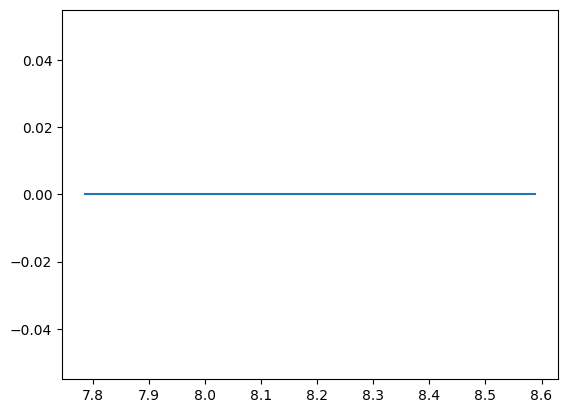

In [8]:
Z_init = calc_Z(dict_to_list(parametre), frequencies)

plt.plot(Z_init.real, -Z_init.imag)
plt.show()

Observe how the parameters are changing with degradation

In [9]:
def finding_params(): 
    dic_list = []
    for l in range(1,6):
        dic_elems, final_diff, frequencies, list_elems = optimize_diff(l)
        dic_list.append(dic_elems)
    
    combined_dict = {}
    
    for d in dic_list:
        for key, value in d.items():
            # If key is not in combined_dict, initialize with empty list
            if key not in combined_dict:
                combined_dict[key] = []
            # Append the value to the list for this key
            combined_dict[key].append(value)

    return combined_dict

In [10]:
combined_dict = finding_params()

def plot_change_param(key_list): 
    x = [1, 2, 3, 4, 5]
    fig, ax = plt.subplots(figsize=(6, 6)) 
    for key in key_list: 
        ax.scatter(x, combined_dict[key], label = key)

    plt.legend()
    plt.xlabel("Data Set Number")
    plt.ylabel("Parameter Value")
    plt.title("Change in Parameters") 
    plt.show()

#plot_change_param(['R1', 'R2'])
#plot_change_param(['Rs', 'Ds'])
#plot_change_param(['C1', 'C2'])
#plot_change_param(['a', 'L'])
#plot_change_param(['K', 'sigma'])
#plot_change_param(['ebsilon'])


/var/folders/18/pf3m4tds5qs9rpymkqv73yxc0000gn/T/ipykernel_12871/1778571784.py:46: OptimizeWarning: Unknown solver options: maxiter
  opt = minimize(diff_func, initial_elems, args=(exp_real, exp_imag), method='TNC', options=options)
/var/folders/18/pf3m4tds5qs9rpymkqv73yxc0000gn/T/ipykernel_12871/1778571784.py:46: OptimizeWarning: Unknown solver options: maxiter
  opt = minimize(diff_func, initial_elems, args=(exp_real, exp_imag), method='TNC', options=options)
/var/folders/18/pf3m4tds5qs9rpymkqv73yxc0000gn/T/ipykernel_12871/1778571784.py:46: OptimizeWarning: Unknown solver options: maxiter
  opt = minimize(diff_func, initial_elems, args=(exp_real, exp_imag), method='TNC', options=options)
/var/folders/18/pf3m4tds5qs9rpymkqv73yxc0000gn/T/ipykernel_12871/1778571784.py:46: OptimizeWarning: Unknown solver options: maxiter
  opt = minimize(diff_func, initial_elems, args=(exp_real, exp_imag), method='TNC', options=options)
/var/folders/18/pf3m4tds5qs9rpymkqv73yxc0000gn/T/ipykernel_12871/177

Comparison plot

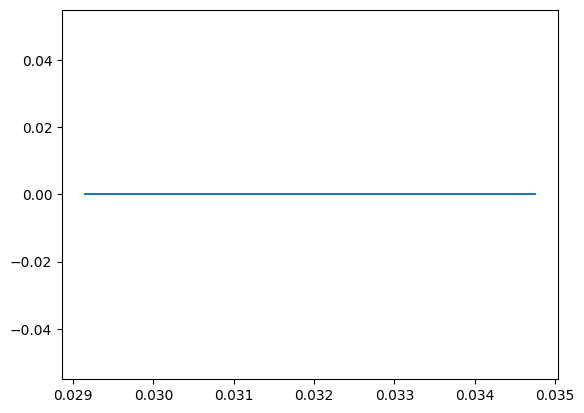

In [11]:
Z = calc_Z(list_elems, frequencies)

plt.plot(Z.real, -Z.imag)
plt.show()

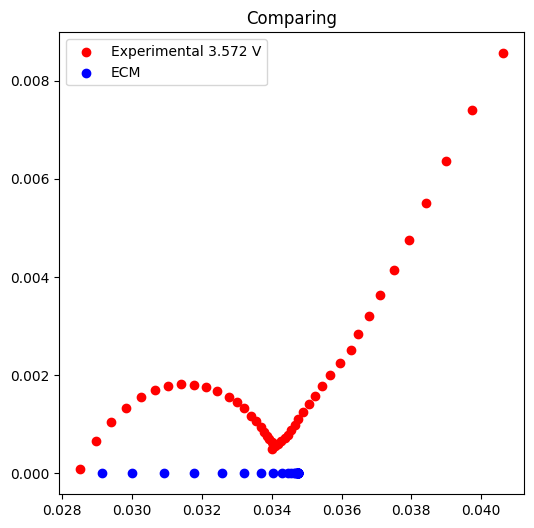

In [12]:

fig, ax = plt.subplots(figsize=(6, 6)) 
ax.scatter(np.array(get_exp_data(i, "")[0][0]), -np.array(get_exp_data(i, "")[0][1]), color = 'red', label=f"Experimental "+str(np.round(get_vdc(i, ""),3))+" V") 
ax.scatter(Z.real, -Z.imag, label = f'ECM', color = 'blue')

#ax.set_xlim(0.016, 0.045) 
#ax.set_ylim(0, 0.012)

plt.legend()
plt.title("Comparing") 
plt.show() 

fig, ax = plt.subplots(figsize=(10, 10)) 
ax.scatter(np.array(get_exp_data(i, "")[0][0]), -np.array(get_exp_data(i, "")[0][1]), color = 'red', label=f"Experimental "+str(np.round(get_vdc(i, ""),3))+" V") 
ax.scatter(Z_randles.real, -Z_randles.imag, label = f'ECM', color = 'blue')

#ax.set_xlim(0.016, 0.045) 
#ax.set_ylim(0, 0.012)

plt.legend()
plt.title("Comparing") 
plt.show() 

In [13]:
def U_n(self, c, c_max):
    sto = c/c_max
    return self.U_n_sto(sto)


def U_p(self, c, c_max):
    sto = c/c_max
    return self.U_p_sto(sto)


def U_n_sto(self, s):
    x = s
    p = np.array([ 1.20912055e+00, 5.62297420e+01, -1.11020020e-01, -2.53458213e-01, 4.92581391e+01, 1.22046522e-02, 4.73538620e-02, 1.79631246e+01, 1.75283209e-01, 1.88038929e-02, 3.03255334e+01, 4.66328034e-01])
    return (p[0] * np.exp(-p[1] * x)+ p[2]- p[3] * np.tanh(p[4] * (x - p[5])) - p[6] * np.tanh(p[7] * (x - p[8])) - p[9] * np.tanh(p[10] * (x - p[11])))


def U_p_sto(self, s):
    x = s
    p = np.array([ 0.74041974, 4.39107343, 0.03434767, 18.16841489, 0.53463176, 17.68283504, 14.59709162, 0.28835348, 17.58474971, 14.69911523, 0.28845641])
    return (-p[0] * x + p[1] - p[2] * np.tanh(p[3] * (x - p[4])) - p[5] * np.tanh(p[6] * (x - p[7]))+ p[8] * np.tanh(p[9] * (x - p[10])))